<a href="https://colab.research.google.com/github/joker2017/Calculator/blob/master/PoseNetDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!python -V

Python 3.6.7


In [1]:
import tensorflow as tf 
print(tf.__version__)

1.12.0


In [3]:
!git clone https://github.com/joker2017/posenet-python

Cloning into 'posenet-python'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 81 (delta 46), reused 76 (delta 44), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [98]:
import os
if not os.path.exists("/content/images"): 
  os.makedirs("/content/images")
!wget -O /content/images/images2.jpg https://instagram.fhen2-1.fna.fbcdn.net/vp/6aa7d059e3e5f0efc6a773d41c79933e/5CBE4FFB/t51.2885-15/e35/47582979_284587508925880_3504868262721009610_n.jpg?_nc_ht=instagram.fhen2-1.fna.fbcdn.net


--2019-01-14 15:03:13--  https://instagram.fhen2-1.fna.fbcdn.net/vp/6aa7d059e3e5f0efc6a773d41c79933e/5CBE4FFB/t51.2885-15/e35/47582979_284587508925880_3504868262721009610_n.jpg?_nc_ht=instagram.fhen2-1.fna.fbcdn.net
Resolving instagram.fhen2-1.fna.fbcdn.net (instagram.fhen2-1.fna.fbcdn.net)... 62.33.34.96, 2a00:1e48:2:15:face:b00c:3333:a3f
Connecting to instagram.fhen2-1.fna.fbcdn.net (instagram.fhen2-1.fna.fbcdn.net)|62.33.34.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98815 (96K) [image/jpeg]
Saving to: ‘/content/images/images2.jpg’

/content/images/ima 100%[===================>]  96.50K   238KB/s    in 0.4s    

2019-01-14 15:03:14 (238 KB/s) - ‘/content/images/images2.jpg’ saved [98815/98815]



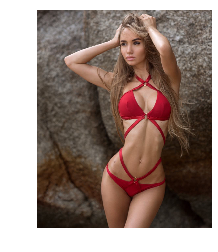

In [99]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
test_image = mpimg.imread("/content/images/images2.jpg")

plt.imshow(test_image, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()

In [106]:
import tensorflow as tf
import cv2
import time
import argparse
import os

import posenet


'''
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=int, default=75)
parser.add_argument('--scale_factor', type=float, default=1.0)
parser.add_argument('--notxt', action='store_true')
parser.add_argument('--image_dir', type=str, default='./images')
parser.add_argument('--output_dir', type=str, default='./output')
args = parser.parse_args()
'''
args_model = 101
args_image_dir = './images'
args_output_dir = './output'
args_notxt = 'store_true'
args_scale_factor = 1.0

with tf.Session() as sess:
        model_cfg, model_outputs = posenet.load_model(args_model, sess)
        output_stride = model_cfg['output_stride']
        print("output_stride:", output_stride)

        if args_output_dir:
            if not os.path.exists(args_output_dir):
                os.makedirs(args_output_dir)

        filenames = [
            f.path for f in os.scandir(args_image_dir) if f.is_file() and f.path.endswith(('.png', '.jpg'))]

        start = time.time()
        for f in filenames:
            input_image, draw_image, output_scale = posenet.read_imgfile(
                f, scale_factor=args_scale_factor, output_stride=output_stride)

            heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = sess.run(
                model_outputs,
                feed_dict={'image:0': input_image}
            )
            #print(heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result)

            pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
                heatmaps_result.squeeze(axis=0),
                offsets_result.squeeze(axis=0),
                displacement_fwd_result.squeeze(axis=0),
                displacement_bwd_result.squeeze(axis=0),
                output_stride=output_stride,
                max_pose_detections=10,
                min_pose_score=0.05)

            keypoint_coords *= output_scale
            #print(pose_scores, keypoint_scores, keypoint_coords)
            if args_output_dir:
                draw_image = posenet.draw_skel_and_kp(
                    draw_image, pose_scores, keypoint_scores, keypoint_coords,
                    min_pose_score=0.02, min_part_score=0.02)            #

                cv2.imwrite(os.path.join(args_output_dir, os.path.relpath(f, args_image_dir)), draw_image)

            '''if not args_notxt:
                print()
                print("Results for image: %s" % f)
                for pi in range(len(pose_scores)):
                    if pose_scores[pi] == 0.:
                        break
                    print('Pose #%d, score = %f' % (pi, pose_scores[pi]))
                    for ki, (s, c) in enumerate(zip(keypoint_scores[pi, :], keypoint_coords[pi, :, :])):
                        print('Keypoint %s, score = %f, coord = %s' % (posenet.PART_NAMES[ki], s, c)) '''

        print('Average FPS:', len(filenames) / (time.time() - start))



output_stride: 16
Average FPS: 0.5794370832748504


In [90]:
model_cfg

{'checkpoint_name': 'mobilenet_v1_101', 'output_stride': 16}

In [41]:
print( os.listdir('/content/output') )

['images2.jpg']


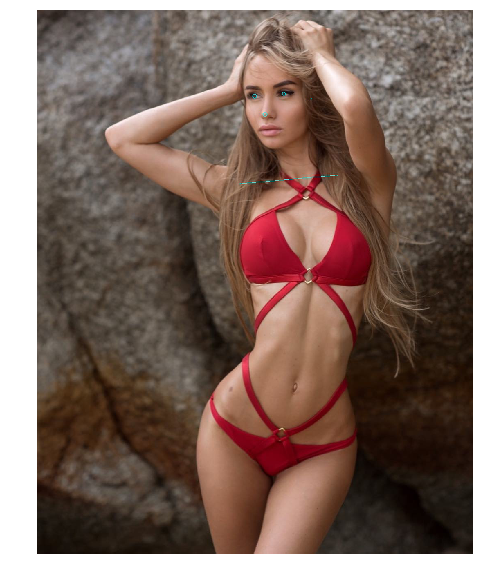

In [108]:
output_image = mpimg.imread("/content/output/images2.jpg")

plt.figure(figsize=(10,10))
plt.imshow(output_image)
plt.axis("off")
plt.show()